In [1]:
import sys, os
from matplotlib import pyplot
import numpy as np
from keras.datasets import cifar10
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import math
 

In [9]:

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 

In [11]:
# define cnn model
def define_model_VGG8():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


# define cnn model
def define_model_VGG5():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [4]:
# CODE MODIFIED FROM TF: Save and load models
def eval_fresh_model():
    
    model = define_model_VGG8()
    # Evaluate the model
    trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    loss, acc = model.evaluate(testX, testY, verbose=2)
    print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))
    
    return model

untrained_model = eval_fresh_model()
untrained_model.summary()

313/313 - 4s - loss: 2.9052 - accuracy: 0.0824
Untrained model, accuracy:  8.24%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________

In [14]:

def sobel_filter_dataset(dataset):
    # convert to tensor and [0,1]
    dataset = tf.convert_to_tensor(np.array(dataset[:,:,:,:])/255)
    dataset = tf.image.sobel_edges(dataset)

    sobel_y = np.asarray(dataset[:, :, :, :, 0]) # sobel in y-direction
    sobel_y = np.clip(sobel_y / 4 + 0.5, 0, 1) # remap to [0,1]

    sobel_x = np.asarray(dataset[:, :, :, :, 1]) # sobel in x-direction
    sobel_x = np.clip(sobel_x / 4 + 0.5, 0, 1) # remap to [0,1]

    dataset = np.clip(0.5*sobel_x + 0.5*sobel_y, 0, 1)
    return dataset




class VisualizeVggFeatures(keras.callbacks.Callback):

    def on_test_end(self,logs={}):

        model = self.model

        num_layers = 6
            
        randomNoise = np.random.rand(1,32,32,3)
        randomNoise = randomNoise * 255
        print(randomNoise.shape)


        layer_outputs = [layer.output for layer in model.layers[:num_layers]] # Gathers the outputs of the layers we want
        activation_model = Model(inputs=model.input, outputs=layer_outputs) # Isolates the model layers from our model
        activations = activation_model.predict(randomNoise) # Returns a list of five Numpy arrays: one array per layer activation

        images_per_row = 16

        layer_names = []
        for layer in model.layers[:num_layers]:
            layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
            

        for layer_name, layer_activation in zip(layer_names, activations): # Iterates over every layer
            n_features = layer_activation.shape[-1] # Number of features in the feature map
            output_size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
            n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
            layer_vis = np.zeros((output_size * n_cols, images_per_row * output_size))


            for col in range(n_cols):
                for row in range(images_per_row):
                    feature = layer_activation[0, :, :, col * images_per_row + row]
                    # Scale and transform the activation for display
                    feature -= feature.mean() # Subtract the mean
                    feature /= feature.std() # Normalize

                    # Don't allow the intensity values to be too large (max 200... over 200 is harsh to look at)
                    feature *= 50
                    feature += 150
                    feature = np.clip(feature, 0, 255).astype('uint8')

                    # displays a panel of 
                    layer_vis[col * output_size : (col + 1) * output_size, 
                                row * output_size : (row + 1) * output_size] = feature
            scale = 1. / output_size
            plt.figure(figsize=(scale * layer_vis.shape[1],
                                scale * layer_vis.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(layer_vis, aspect='auto', cmap='plasma')


# run the test harness for evaluating a model
def eval_trained_model_VGG8():

    file_dir = os.path.dirname(os.path.realpath('__file__')) #<-- absolute dir this file is in
    abs_file_path_chkpt = os.path.join(file_dir, 'vgg_8_checkpoints/vgg8.chkpt')
   
    model = define_model_VGG8()
    model.load_weights(abs_file_path_chkpt)
    # Evaluate the model
    trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    plot_metrics = VisualizeVggFeatures()
    loss, acc = model.evaluate(testX, testY, verbose=2, callbacks = [plot_metrics])
    print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))
    
    return model

# run the test harness for evaluating a model
def eval_trained_model_VGG5():

    file_dir = os.path.dirname(os.path.realpath('__file__')) #<-- absolute dir this file is in
    abs_file_path_chkpt = os.path.join(file_dir, 'vgg_5_sobel2_checkpoints/vgg5_sobel2.chkpt')
   
    model = define_model_VGG8()
    model.load_weights(abs_file_path_chkpt)
    # Evaluate the model
    (trainX, trainY), (testX, testY) = cifar10.load_data()
	# prepare pixel data
    # trainX, testX = prep_pixels(trainX, testX)
    trainX = sobel_filter_dataset(trainX)
    testX = sobel_filter_dataset(testX)
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    plot_metrics = VisualizeVggFeatures()
    loss, acc = model.evaluate(testX, testY, verbose=2, callbacks = [plot_metrics])
    print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))
    
    return model

trained_model= eval_trained_model_VGG5()  
trained_model.summary()  




Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1639562e8> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x163af6710>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x163af6710> and <tensorflow.python.keras.layers.core.Dropout object at 0x1639ac2e8>).


ValueError: Tensor's shape (3, 3, 3, 128) is not compatible with supplied shape (3, 3, 3, 32)

(1, 32, 32, 3)
16
(1, 32, 32, 3)
16
/Users/andrewweng/Developer/pyvenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


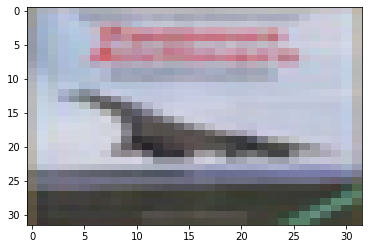

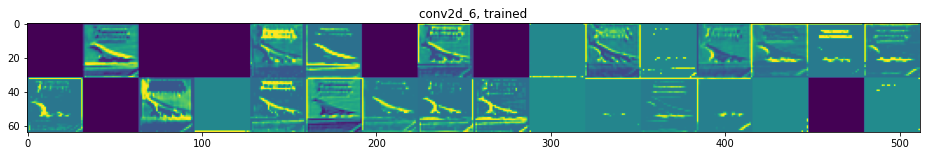

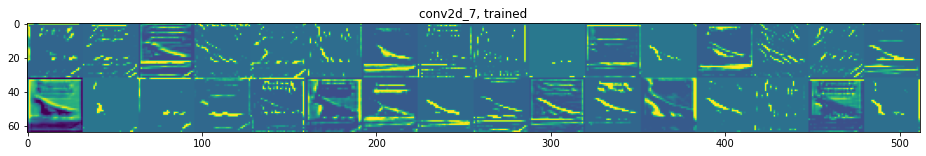

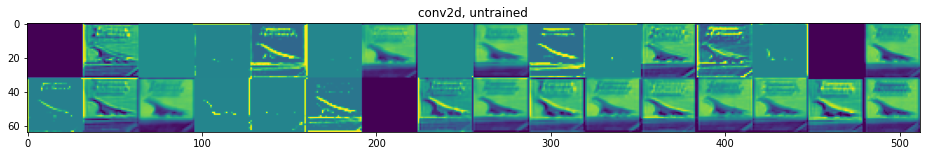

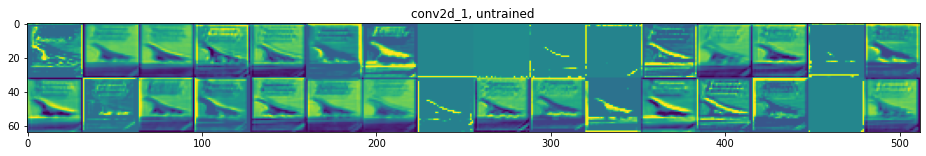

In [51]:

# MODIFIED FROM: Visualizing intermediate activation in Convolutional Neural Networks with Keras

# model.summary()

# sampleX = sampleX.reshape(1,32,32,3)
# print(sampleX.shape)

# layer = model.layers[0]
# layer_1_output = layer_1.output
# activation_model = Model(inputs=model.input, outputs=layer_1_output)
# layer_1_activations = activation_model.predict(sampleX)

# print(layer_1_activations.shape)

# plt.matshow(layer_1_activations[0, :, :, 4], cmap='viridis')


# layer_names = []
# for layer in model.layers[:12]:
#     layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

# layer_names = layer_1.name


def vis_top_2_activations(model, sampleX, model_type):

    sampleX = sampleX.reshape(1,32,32,3)
    print(sampleX.shape)

    print(len(model.layers))


    layer_outputs = [layer.output for layer in model.layers[:16]] # Extracts the outputs of the top 12 layers
    activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
    activations = activation_model.predict(sampleX) # Returns a list of five Numpy arrays: one array per layer activation

    images_per_row = 16

    layer_names = []
    for layer in model.layers[:15]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
        

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).

        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                feature_image = layer_activation[0,:,:,col * images_per_row + row]
                feature_image -= feature_image.mean() # Post-processes the feature to make it visually palatable
                feature_image /= feature_image.std()
                feature_image *= 64
                feature_image += 128


                feature_image = np.clip(feature_image,0,255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                        row * size : (row + 1) * size] = feature_image
     

                # total_display_grid = np.zeros((display_grid.shape[0],display_grid.shape[1]))
                # total_display_grid[:,:] = display_grid
                # total_display_grid[:,:,1] = display_grid_channel_2
                # total_display_grid[:,:,2] = display_grid_channel_3

                # print(total_display_grid.shape)

                
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name + ", " + model_type) 
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


trainX, trainY, testX, testY = load_dataset()
sampleX = testX[3,:,:,:]
plt.imshow(sampleX, aspect='auto', cmap='viridis')



vis_top_2_activations(trained_model,sampleX,"trained")
vis_top_2_activations(untrained_model,sampleX,"untrained")



(1, 32, 32, 3)
16
(1, 32, 32, 3)
16
/Users/andrewweng/Developer/pyvenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


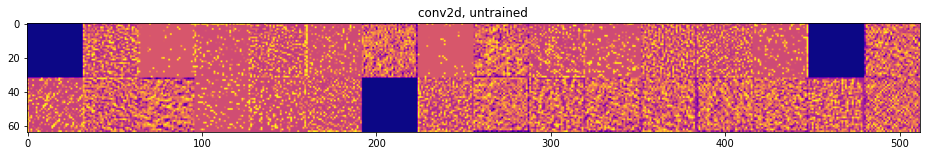

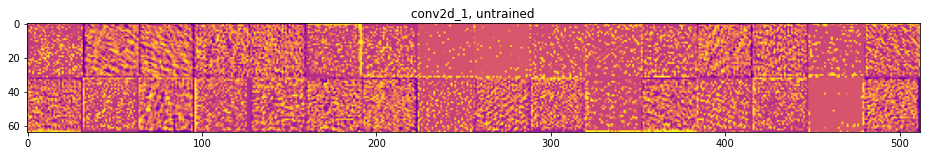

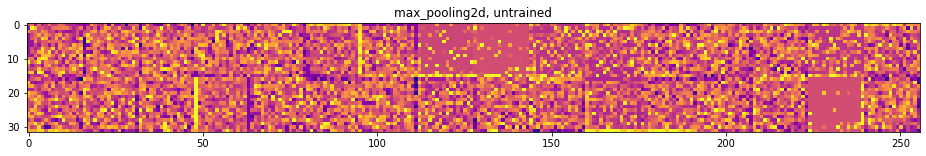

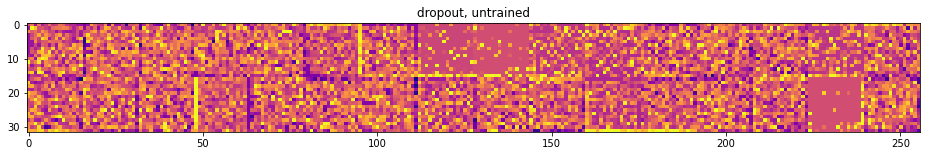

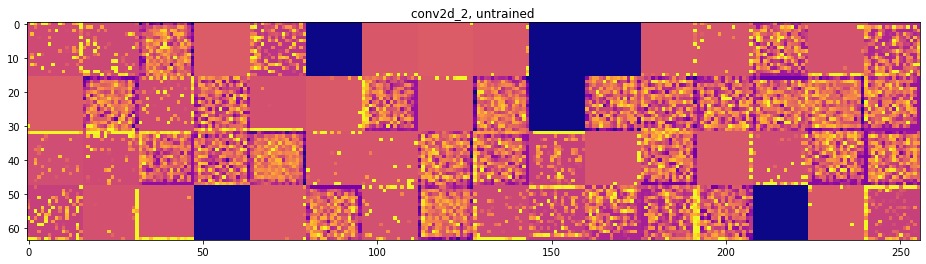

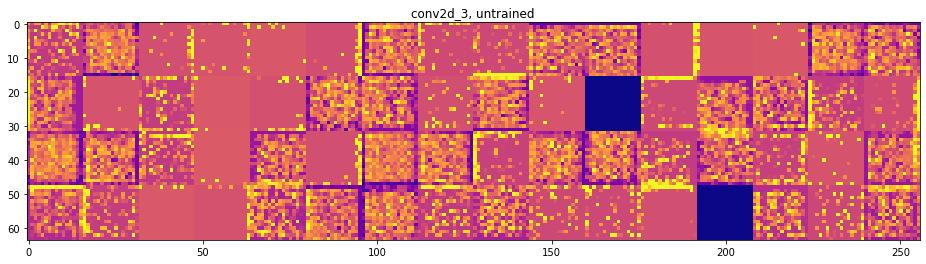

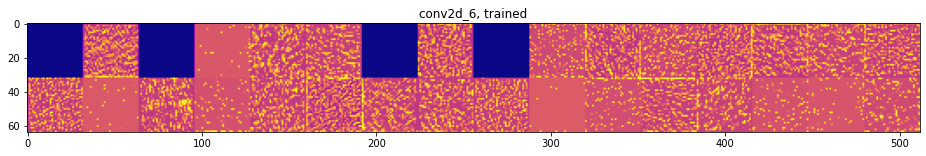

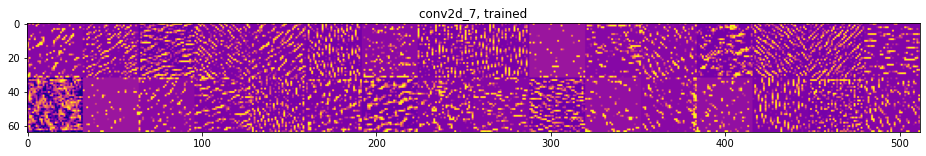

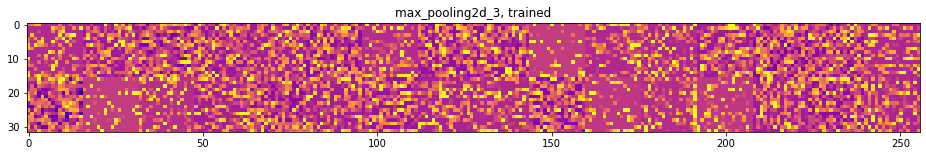

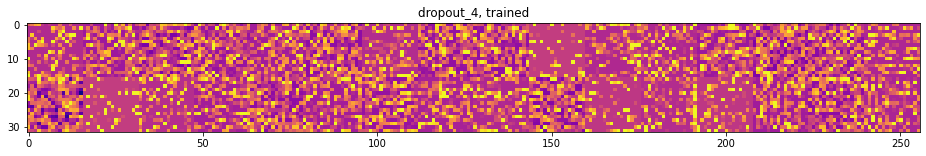

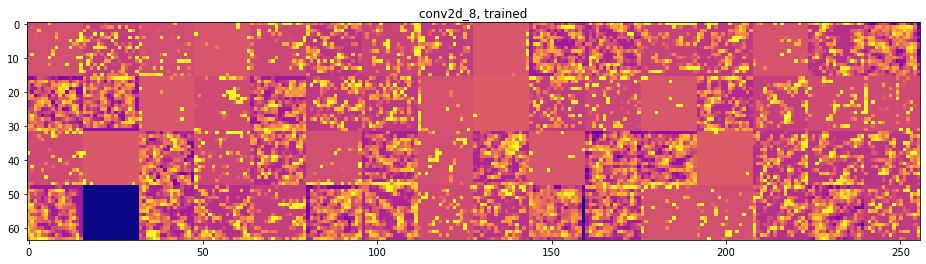

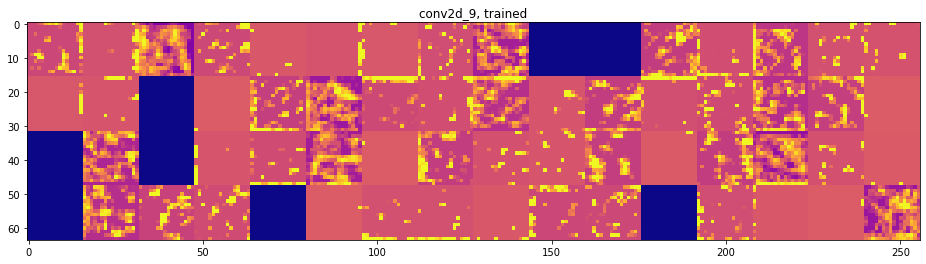

In [55]:

# MODIFIED FROM: Visualizing intermediate activation in Convolutional Neural Networks with Keras
def visualize_features(model,model_type, num_layers):


    randomNoise = np.random.rand(1,32,32,3)
    randomNoise = randomNoise * 255
    print(randomNoise.shape)

    print(len(model.layers))


    layer_outputs = [layer.output for layer in model.layers[:num_layers]] # Gathers the outputs of the layers we want
    activation_model = Model(inputs=model.input, outputs=layer_outputs) # Isolates the model layers from our model
    activations = activation_model.predict(randomNoise) # Returns a list of five Numpy arrays: one array per layer activation

    images_per_row = 16

    layer_names = []
    for layer in model.layers[:num_layers]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
        

    for layer_name, layer_activation in zip(layer_names, activations): # Iterates over every layer
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        output_size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        layer_vis = np.zeros((output_size * n_cols, images_per_row * output_size))


        for col in range(n_cols):
            for row in range(images_per_row):
                feature = layer_activation[0, :, :, col * images_per_row + row]
                # Scale and transform the activation for display
                feature -= feature.mean() # Subtract the mean
                feature /= feature.std() # Normalize

                # Don't allow the intensity values to be too large (max 200... over 200 is harsh to look at)
                feature *= 50
                feature += 150
                feature = np.clip(feature, 0, 255).astype('uint8')

                # displays a panel of 
                layer_vis[col * output_size : (col + 1) * output_size, 
                            row * output_size : (row + 1) * output_size] = feature
        scale = 1. / output_size
        plt.figure(figsize=(scale * layer_vis.shape[1],
                            scale * layer_vis.shape[0]))
        plt.title(layer_name + ", " + model_type)
        plt.grid(False)
        plt.imshow(layer_vis, aspect='auto', cmap='plasma')


visualize_features(untrained_model,"untrained",6)
visualize_features(trained_model,"trained",6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(3, 3, 3, 32)


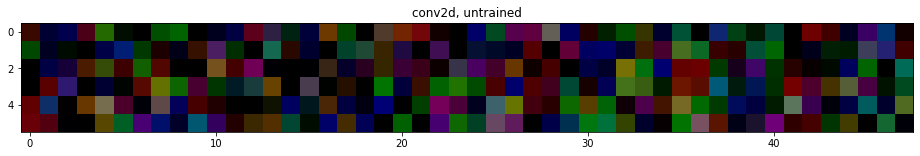

(3, 3, 3, 32)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


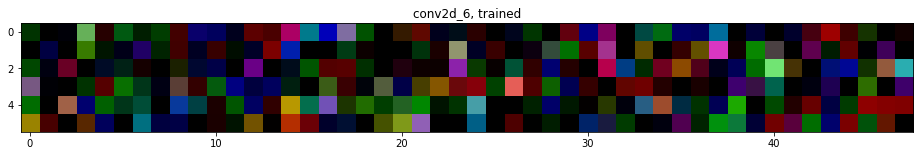

In [43]:

def vis_top_2_weights(model, model_type):


    images_per_row = 16

    layer_names = []
    for layer in model.layers[:2]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    # layers = model.layers[:2]
    weights,biases = [layer.get_weights() for layer in model.layers[:2]]

    layer_1_name = layer_names[0]
    layer_2_name = layer_names[1]
    layer_1_weights = weights[0]
    layer_2_weights = weights[0]

    print(layer_1_weights.shape)
     
    images_per_row = 16
    

    n_filters = layer_1_weights.shape[-1] # Number of features in the feature map
    size = layer_1_weights.shape[0] #The feature map has shape (1, size, size, n_features).
    n_cols = n_filters // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size,3))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_1_weights[:,:, :,col * images_per_row + row]
            display_grid[col * size : (col + 1) * size, # Displays the grid
                        row * size : (row + 1) * size,:] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_1_name + ", " + model_type)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

    return layer_1_weights



untrained_weights = vis_top_2_weights(untrained_model, "untrained")
trained_weights = vis_top_2_weights(trained_model, "trained")


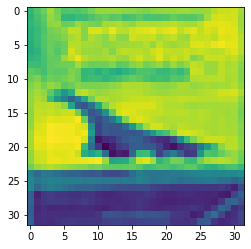

(3, 3)
done
done
done


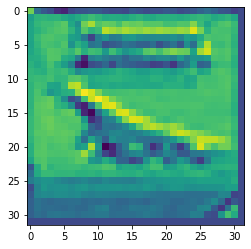

NameError: name 'hist' is not defined